In [8]:
### INCLUDES

# show graphics in jupyter
#%pylab inline

import scipy
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import copy


In [35]:
### IMPORTING DATA functions

# samplerate of the data (samples/sec.)
samplerate = 44100.

# bit depth of the data
bitdepth = np.int16

# attack (in sec.)
attack_duration = 0.4

# when a wav audio is noise
# TODO: very arbitrary
threshold_wav = 30

# input: a .wav file 
# output: a vector of integers (one float per sample)
def import16monowav(wav_file) :
    samplerate, data = wavfile.read(wav_file)
    #return np.fromfile(open(wav_file),bitdepth)[24:]
    return data

def import16stereo1wav(wav_file) :
    samplerate, data = wavfile.read(wav_file)
    #return np.fromfile(open(wav_file),bitdepth)[24:]
    res = [n for n,m in data]
    return res

# normalize to a float in [-1,1]
def normalize16bits(vector) :
    return [ sample/2**16. for sample in vector ]

# kills first nad last samples under some threshold
def killsilence_wav(wav_16bits) :
    first = 0
    last = len(wav_16bits)-1
    while (abs(wav_16bits[first]) < threshold_wav) :
        first += 1
    while (abs(wav_16bits[last]) < threshold_wav) :
        last -= 1
    if first >= last :
        raise ValueError('This audio seems to be pure noise!')
    return wav_16bits[first:last]


# convert to float
# input: a wav file
# output: a vector of floats in [-1,1]
# TODO: the silence should be removed later?
def convert_to_float(ex) :
    if channels == 1 :
        imported = import16monowav(ex)
    else :
        imported = import16stereo1wav(ex)
    return normalize16bits(killsilence_wav(imported))
        
    
# import wav, convert to float, take pieces and fourier transform each piece
# input: a wav file
# output: a list of transforms of windows of the audio
def import_convert_transform2(ex) :
    # import wav and convert to float
    ex_float = convert_to_float(ex)
    windows = attack_and_release(ex_float)
    volumeswindows = list(map(rms,windows))
    attackvolume = volumeswindows[0]
    volumeswindows_relative = volumeswindows/attackvolume
    return list(map(transform_floats, windows)), volumeswindows_relative[1:]

 
# de comun
def import_convert_transform(ex) :
    # import wav and convert to float
    ex_float = convert_to_float(ex)
    windows = attack_and_release(ex_float)
    return transform_floats(windows[1])


# given a float vector (signal) divide it in attack and the rest
def attack_and_release(vec) :
    attack_samples_over2 = int(samplerate * attack_duration/2)
#    print "the number of samples in the attack is: " + str(2*attack_samples_over2)
#    print "the number of samples in the release is: " + str(4*attack_samples_over2)
    attack = vec[: 2*attack_samples_over2] 
    release_possiblytooshort = vec[attack_samples_over2 : 5*attack_samples_over2]
    tooshort = 4*attack_samples_over2 - len(release_possiblytooshort)
    release = np.pad(release_possiblytooshort,[(0,tooshort)],'constant')
    return [attack, release]
    

#parameter for tukey window
alpha_tukey = 0.05

howmuchtopad = 1000

# given a signal of floats, apply window and transform
def transform_floats(ex_float) :
    # apply tukey window
    ex_windowed = signal.tukey(len(ex_float),alpha=0.05) * ex_float  
    # pad with some zeros
    ex_padded = np.pad(ex_windowed,[(howmuchtopad,howmuchtopad)],'constant')
    # transform to frequency domain (since this is a real signal the transformed vector has half of the length)
    ex_transformed_complex = np.fft.rfft(ex_padded)
    # take absolute values
    ex_transformed = map(abs,ex_transformed_complex)
    # compute frequencies for the xlabel
    freq_label = np.fft.rfftfreq(len(ex_padded),1/samplerate)
    
    # TODO: Plancherel's theorem does not seem to be holding :(
    #print "norm of signal: " + str(rms(ex_windowed))
    #print "norm of transformed: " + str(rms(ex_transformed))
    
    return ex_transformed, freq_label
    #freq_label = [ np.arange(len(ex))/(len(ex)*2/samplerate) for ex in ex_transformed ]

In [13]:
### FINIDING HARMONICS functions


# TODO: this should not be sooo hardcoded 
peak_width_min = 10
peak_width_max = 20

# a semi tone
sm_tone = 2**(1/12.)
tone = 2**(1/6.)


# range of harmonics of interest
# TODO: hardcode this better
relevant_range_min = 100.
relevant_range_max = 15000.
# how many harmonics we want to take into account
num_harmonics = 9


def harmonics_energy(ex, frq_lbl) :
    ex = list(ex)
    # the total spectrum has len(ex) samples and the spectrum has 44100/2 frequencies
    max_frequency = samplerate/2
    exinitial = int(len(ex)/max_frequency * relevant_range_min)
    exfinal = int(len(ex)/max_frequency * relevant_range_max)
        # print("the minum relevant frequency is: " + str(frq_lbl[exinitial]))
        # print("this is the actual maximum: " + str(frq_lbl[len(ex)-1]))
        # print("this is the length of the example: " + str(len(ex)))
    # find tonic
    tonic_pos = np.argmax(ex[exinitial:exfinal]) + exinitial
    # compute the energy of the harmonics
    peaks_energy = [ sum(interval_to_integrate(ex,tonic_pos*n)) for n in range(1,num_harmonics+1) ]
    # and normalize with the energy of the tonic
    tonic_energy = peaks_energy[0]
    peaks_energy_nor = [ harmonic_energy/tonic_energy for harmonic_energy in peaks_energy ]
    #the frequency of the peaks
    peaks_frequency = [ (frq_lbl[tonic_pos*n] if tonic_pos*n<len(frq_lbl) else 0.) for n in range(1,num_harmonics+1) ]
    #print "the tonic is: " + str(peaks_frequency[0])
    return peaks_frequency, peaks_energy_nor
    
    
# interval of 200Hz centered at the note
def interval_to_integrate(ex, peak) :
    width_of_average = 200.
    # the total spectrum has len(ex) samples and the spectrum has 44100/2 frequencies
    max_frequency = samplerate/2
    hz_in_samples = len(ex)/max_frequency * width_of_average
    windowinitial = int(peak-hz_in_samples/2) 
    windowfinal = int(peak+hz_in_samples/2)
    #print "the length in samples of the average window is: " + str(windowfinal-windowinitial)
    return ex[windowinitial:windowfinal]


# root mean square of a vector
def rms(vec) :
    return np.sqrt(np.average(np.power(vec,2)))

def sumofsquares(vec) :
    return sum(np.power(vec,2))

# l^2 norm of a vector
def l2n(vec) :
    return np.sqrt(sumofsquares(vec))


## NOT USED ---------------------------------


# TODO: should be called harmonics_amplitudes
def harmonics_frequency_volumes(ex, frq_lbl) :
    # filter peaks in range
    peaks_position = find_peaks_in_range(ex, frq_lbl)
    
    # compute energy of peaks (root mean square):
    peaks_energy_tmp = [ get_l2n_peak_Hz(ex,peak) for peak in peaks_position ]
    
    # find tonic
    tonic_pos = find_tonic(peaks_energy_tmp)
    #take only num_harmonics peaks
    peaks_energy = peaks_energy_tmp[tonic_pos:tonic_pos+num_harmonics]
        #print "the energy of the peaks: " + str(peaks_energy)
    # calculate volume of peaks relative to tonic
    tonic_energy = peaks_energy[0]
    peaks_energy_nor = [ harmonic_energy/tonic_energy for harmonic_energy in peaks_energy ]
        #print "the energy of the peaks normalized: " + str(peaks_energy_nor)
        ## normalize by rms
        #peaks_volume_nor = peaks_volume/rms(peaks_volume)
        
        ## put volumes in range
        ##peaks_volume_in_range = [ v-min_volume if v>min_volume else 0 for v in peaks_volume ]
    #the frequency of the peaks
    peaks_frequency = [ frq_lbl[n] for n in peaks_position[tonic_pos:tonic_pos+num_harmonics] ]
    return peaks_frequency, peaks_energy_nor

# given a signal return a list of the positions of the peaks
def find_peaks_in_range(ex, frq_lbl) :
    # find peaks (this is the position in the array)
    peaks = signal.find_peaks_cwt(ex, np.arange(peak_width_min,peak_width_max))
    peaks_in_range = filter(lambda n : frq_lbl[n]>=relevant_range_min and frq_lbl[n]<= relevant_range_max, peaks)
    return peaks_in_range


def find_tonic(amplitudes) :
    maximum = max(amplitudes)
    arbitrary = 2.
    first = 0
    while (amplitudes[first] < maximum/arbitrary) :
        first += 1
    if first >= len(amplitudes) :
        raise ValueError('No tonic!')
    return first


# TODO: see if this parameter is ok
tolerance_har = 0.2


def cast_harmonics(peaks_frequency, peaks_volume) :
    har_f_har_v = zip(peaks_frequency, peaks_volume)
    tonic_freq = har_f_har_v[0][0]
    peaks_volume_res = np.zeros(num_harmonics)
    peaks_frequency_new = [ tonic_freq * n for n in range(1,num_harmonics+1)]
    
    for freq, vol in har_f_har_v :
        harm_num = int(round(freq/tonic_freq))
        print("found a harmonic of number " + str(harm_num))
        print("its real frequency is " + str(freq))
        if abs(freq/tonic_freq - harm_num) > tolerance_har or harm_num > num_harmonics :
            print("i killed it :(")
            print("WARNING: strange harmonic: " + str(freq/tonic_freq))
        else :
            print("i kept it")
            peaks_volume_res[harm_num-1] = vol
            peaks_frequency_new[harm_num-1] = freq
        
    return peaks_frequency_new, peaks_volume_res
 

# rms over two tones centered at the note
def get_rms_peak_log(ex, peak) :
    windowinitial = int(peak/tone) 
    windowfinal = int(peak*tone)
    return rms(ex[windowinitial:windowfinal])

# l2n over two tones centered at the note
def get_l2n_peak_log(ex, peak) :
    windowinitial = int(peak/tone) 
    windowfinal = int(peak*tone)
    return l2n(ex[windowinitial:windowfinal])
 
# average over two tones centered at the note
def get_amplitude_peak_log(ex, peak) :
    windowinitial = int(peak/tone) 
    windowfinal = int(peak*tone)
    return np.average(ex[windowinitial:windowfinal])

# rms over a neigborhood of the peak
def get_rms_peak(ex, peak) :
    # TODO: this 10 is pretty arbitrary
    windowinitial = int(peak-peak_width_max/2) 
    windowfinal = int(peak+peak_width_max/2)
    return rms(ex[windowinitial:windowfinal])

# with a change of parameter
# TODO: do the integral with np.average
def get_amplitude_peak_log_log(ex, peak) :
    # v_n(x) = v_f(2^x),  thus \int v_n(x) = \int v_f(2^x) = \int v_f(y)/y
    windowinitial = int(peak/sm_tone) 
    windowfinal = int(peak*sm_tone)
    lenintegral = windowfinal - windowinitial
    weights = [ 1/float(y) for y in range(windowinitial,windowfinal) ]
    totalweights = sum(weights)
    averagevol = sum([v*w for v,w in zip(ex[windowinitial:windowfinal], weights)])/totalweights
    return averagevol


In [4]:
### PLOTTING functions



# plot (1/4 of the) spectrum 
def plotspec() :
    color = iter(plt.cm.rainbow(np.linspace(0,1,len(names_and_graphs_and_harm_number))))
    for (name, ex, freqs), (x,y) in names_and_graphs_and_harm_number :
        c = next(color)
        plt.plot(freqs, ex, label=name,c=c)
    
# logarithmic scale for x axis [log(frequency) = note]
def plotspec_log() :
    color = iter(plt.cm.rainbow(np.linspace(0,1,len(names_and_graphs_and_harm_number))))
    for (name, ex, freqs), (x,y) in names_and_graphs_and_harm_number :
        c = next(color)
        plt.plot(np.log2(freqs), ex, label=name,c=c)
    

# logarithmic scale for both axes [log(frequency) = note, log(amplitude) = volume]
def plotspec_loglog() :
    color = iter(plt.cm.rainbow(np.linspace(0,1,len(names_and_graphs_and_harm_number))))
    for (name, ex, freqs), (x,y) in names_and_graphs_and_harm_number :
        ex = np.log2(ex)
        c = next(color)
        plt.plot(np.log2(freqs), ex, label=name,c=c)
 
    
def plotspec_normalized() :
    color = iter(plt.cm.rainbow(np.linspace(0,1,len(names_and_graphs_and_harm_number))))
    for (name, ex, freqs), (x,y) in names_and_graphs_and_harm_number :
        c = next(color)
        #normalize
        ex /= np.max(np.abs(ex),axis=0)
        plt.plot(freqs, ex, label=name,c=c)

def plotspec_and_harmonics() :
    color = iter(plt.cm.rainbow(np.linspace(0,1,len(names_and_graphs_and_harm_number))))
    for (name, ex, freqs), (x,y) in names_and_graphs_and_harm_number :
        c = next(color)
        # normalize
        ex /= np.max(np.abs(ex),axis=0)
        #ex /= rms(ex)
        plt.plot(freqs, ex, label=name,c=c)
        plt.scatter(x,y , label=name,c=c)
#        plt.ylim([0,1])

    
def plotspec_and_harmonics_log() :
    color = iter(plt.cm.rainbow(np.linspace(0,1,len(names_and_graphs_and_harm_number))))
    for (name, ex, freqs), (x,y) in names_and_graphs_and_harm_number :
        c = next(color)
        # in decibels
        ex = np.log2(ex)
        # normalize
        ex /= np.max(np.abs(ex),axis=0)
        plt.plot(freqs, ex, label=name,c=c)
        plt.scatter(x, y, label=name,c=c)
#        plt.ylim([0,1])
    
# no color version
def plotharmonics_nc() :
    for (name, ex, freqs), (x,y) in names_and_graphs_and_harm_number :
        xx = range(len(y))
        plt.scatter(xx, y,label=name)
    
def plotharmonics() :
    color = iter(plt.cm.rainbow(np.linspace(0,1,len(names_and_graphs_and_harm_number))))
    for (name, ex, freqs), (x,y) in names_and_graphs_and_harm_number :
        c = next(color)
        xx = range(len(y))
        plt.scatter(xx, y,label=name,c=c)
    

def plotharmonics2() :
    color = iter(plt.cm.rainbow(np.linspace(0,1,len(names_and_graphs_and_harm_number))))
    for (name, ex, freqs), (x,y) in names_and_graphs_and_harm_number :
        c = next(color)
        plt.plot(y,label=name,c=c)

In [98]:
### IMPORTING SYNTHETIC SINUSOIDS functions and call

Ts = 1.0/samplerate

def gimme_sinusoid(freq) :
    t = np.arange(0,1,Ts)
    return np.sin(2*np.pi * freq * t)
    
def gimme_sinusoids(freq,harmonics_amp) :
    n = 2
    res = gimme_sinusoid(freq)
    for amp in harmonics_amp : 
        res += amp * gimme_sinusoid(n*freq)
        n += 1
    return res

def gimme_sinusoids_noise(freq,harmonics_amp) :
    signal = gimme_sinusoids(freq,harmonics_amp)
    return signal + np.random.normal(0,.5,len(signal))

        
algunos = [gimme_sinusoids_noise(500,[.8,.4,.8,.8,.6,.5,.1,.1]),
          gimme_sinusoids(400,[.5,.3,.4,.5,.6,.7,.1,.1])]
namos = ['500','400']

# more global variables
ex_transformed, freq_label = list(zip(*map(transform_floats, algunos)))
names_and_graphs = list(zip(namos, ex_transformed, freq_label))



#plt.plot(ex_transformed[0])
#plt.show()


In [104]:
### IMPORTING DATA calls


# global variables
# directory with data
#datadirectory = "./sonatina_symphonic_orchestra/Samples/Flute/"
datadirectory = "./flute/philharmonia/"

# maximum of examples
max_ex = 5

# channels
# TODO: do not hardcode this!
channels = 1

# file names
ex_wav = glob.glob(datadirectory + '*.wav')[:max_ex]

# TODO: a human-readble version of ex_wav
# ex_names = 


# more global variables
ex_transformed, freq_label = list(zip(*map(import_convert_transform, ex_wav)))
names_and_graphs = list(zip(ex_wav, ex_transformed, freq_label))

In [105]:
### FINDING HARMONICS calls

#harmonic_volumes_every_example = [ harmonics_frequency_volumes(ex_tr, freq_lbl) for ex_name , ex_tr, freq_lbl in names_and_graphs ]
#harmonic_number_volumes_every_example = [ cast_harmonics(f,v) for f,v in harmonic_volumes_every_example ]
harmonic_number_volumes_every_example = [ harmonics_energy(ex_tr, freq_lbl) for ex_name , ex_tr, freq_lbl in names_and_graphs ]


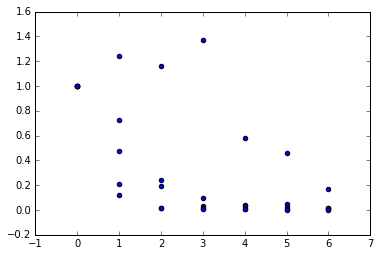

In [106]:
### PLOTTING calls

# get data
#names_and_graphs_and_harm = zip(names_and_graphs, harmonic_volumes_every_example)
names_and_graphs_and_harm_number = list(zip(names_and_graphs, harmonic_number_volumes_every_example))

# plot

minfreq_plot = 60
maxfreq_plot = 4000

plotharmonics_nc()
#plotharmonics()
#plotharmonics2()
#plotspec_and_harmonics()

#plt.legend(loc='upper right')
#plt.yscale('log')
#plt.xlim([minfreq_plot,maxfreq_plot])
plt.show()

#plt.plot([0,1,2])
#plt.show()

In [73]:
### LEARN functions

datadirectory1 = "./flute/philharmonia/"
datadirectory2 = "./oboe/philharmonia/"

howmanyexamples = 700

channels = 1

ex_wav1 = glob.glob(datadirectory1 + '*.wav')[:howmanyexamples]
ex_wav2 = glob.glob(datadirectory2 + '*.wav')[:howmanyexamples]

#ex_transformed1, freq_label1 = zip(*map(import_convert_transform, ex_wav1))
#ex_transformed2, freq_label2 = zip(*map(import_convert_transform, ex_wav2))

# zip(ex_transformed1, freq_label1)
# zip(ex_transformed2, freq_label2)

trandlbl1ar, vd1 = list(zip(*map(import_convert_transform2, ex_wav1)))
trandlbl2ar, vd2 = list(zip(*map(import_convert_transform2, ex_wav2)))

trandlbl1a, trandlbl1r = list(zip(*trandlbl1ar))
trandlbl2a, trandlbl2r = list(zip(*trandlbl2ar))


### LEARN 2

#print(trandlbl1a[0])



energylbl1a_withmore_ = [ harmonics_energy(ex_tr, freq_lbl) for ex_tr, freq_lbl in trandlbl1a ]
energylbl2a_withmore_ = [ harmonics_energy(ex_tr, freq_lbl) for ex_tr, freq_lbl in trandlbl2a ]

energylbl1r_withmore_ = [ harmonics_energy(ex_tr, freq_lbl) for ex_tr, freq_lbl in trandlbl1r ]
energylbl2r_withmore_ = [ harmonics_energy(ex_tr, freq_lbl) for ex_tr, freq_lbl in trandlbl2r ]


### make a copy since we will shuffle the inputs and the shuffling works in place!
energylbl1a_withmore = copy.deepcopy(energylbl1a_withmore_)
energylbl2a_withmore = copy.deepcopy(energylbl2a_withmore_)
energylbl1r_withmore = copy.deepcopy(energylbl1r_withmore_)
energylbl2r_withmore = copy.deepcopy(energylbl2r_withmore_)


/usr/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in double_scalars


In [116]:
### LEARN 3


howmanyharmonics = 7

# forget the frequencies
# and forget the first volume which is always 1
def only_volumes(energylbl) :
    return list(map(lambda l : l[1][1:howmanyharmonics+1], energylbl))

# take only non nan from a list
def cleannan(l):
    return [x for x in l if not isnan(x)]

# input: list of lists
# output: only lists that do not contain any nans
def cleannan2(l):
    return [x for x in l if np.isfinite(x).all()]


energylbl1a = only_volumes(energylbl1a_withmore)
energylbl1r = only_volumes(energylbl1r_withmore)
energylbl2a = only_volumes(energylbl2a_withmore)
energylbl2r = only_volumes(energylbl2r_withmore)


# we can put l1 and l2, or just l2.
# it seems to work better with just l2
energylbl1 = [ l2 for l1, l2, v in zip(energylbl1a,energylbl1r,vd1)]
energylbl2 = [ l2 for l1, l2, v in zip(energylbl2a,energylbl2r,vd2)]


volumes1 = cleannan2(energylbl1)
volumes2 = cleannan2(energylbl2)
#shuffle the inputs (this is in place )
random.seed(3)
random.shuffle(volumes1)
random.shuffle(volumes2)


#nthvolume = [ map(lambda l : l[n], only_volumes) for n in range(0,num_harmonics) ]
#
#nthvolumecleaned = map(cleannan, nthvolume)
#
#averages = map(average, nthvolumecleaned)
#
#minusaverages = [ map(lambda m : m-averages[n], nthvolumecleaned[n]) for n in range(0,num_harmonics) ]
#
#variances = map(rms, minusaverages)
#
#variances, averages

#print(vd1[2])

In [117]:
### LEARN 4

from sklearn import neighbors, svm

#fractiontrain = 9./10.
fractiontrain = 5./6.
#fractiontrain = 4./5.
#fractiontrain = 1./100.

#training examples
trainvolumes1 = volumes1[:int(len(volumes1)*fractiontrain)]
trainvolumes2 = volumes2[:int(len(volumes2)*fractiontrain)]

howmanytrain1 = len(trainvolumes1)
howmanytrain2 = len(trainvolumes2)
howmanytrain = howmanytrain1 + howmanytrain2

#testing examples
testvolumes1 = volumes1[int(len(volumes1)*fractiontrain):len(volumes1)]
testvolumes2 = volumes2[int(len(volumes2)*fractiontrain):len(volumes2)]

howmanytest1 = len(testvolumes1)
howmanytest2 = len(testvolumes2)


training_ex = trainvolumes1 + trainvolumes2
labels = [ 1 for i in range(0,howmanytrain1) ] + [ 0 for i in range(0,howmanytrain2) ]


#########################

## assert: there are no testing samples in the training set

def is_in(e,l):
    res = False
    for v in l:
        for f1,f2 in zip(e,v):
            if f1 == f2 :
                res = True
    return res
            
#testing: is_in([1.],[[0.],[0.,4,3],[1.]])
    
alltests = testvolumes1 + testvolumes2

datasnooping = any([ is_in(test, training_ex) for test in alltests ])
if datasnooping :
    print("WARNING: you are testing on the training set")
print("doing data snooping? " + str(datasnooping))

doing data snooping? False


In [118]:
### Learning algorithm


training_ex = trainvolumes1 + trainvolumes2
labels = [ 1 for i in range(0,howmanytrain1) ] + [ 0 for i in range(0,howmanytrain2) ]





## SVN does not seem to work
#clf = svm.SVC(kernel='linear')
#clf.fit(training_ex, labels) 

# nearest neighboor
n_neighbors = 5
clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(training_ex, labels) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [119]:
### CALCULATING ERROR

print("training with: " + str(howmanytrain))
print("testing with: " + str(howmanytest1 + howmanytest2))

goods1 = list(clf.predict(testvolumes1))
goods2 = [ 1-x for x in clf.predict(testvolumes2) ]

error = 1. - np.average(goods1+goods2)

print("error: " + str(error))


training with: 1021
testing with: 206
error: 0.184466019417


In [608]:

def only_volumes1(energylbl) :
    return list(map(lambda l : l[1][1:], energylbl))

#only_volumes(energylbl1)

In [370]:
set([1,2]).intersection(set([1]))

{1}

In [467]:
a = [1,2,3,4,5,6]
np.random.seed(3)
np.random.shuffle(a)
a

[4, 6, 5, 2, 1, 3]

In [9]:
a = [1,2]
b = copy.copy(a)